# Learning with constraints


## Objective
This notebook contains a very simple example showing how to train a feedforward neural network with human-driven constraints.


## Outline
- [Objective](#Objective)
- [Problem description](#Problem-description)
    - [Multi-label classification](#Multi-label-classification)
    - [Humans don't like black boxes](#Humans-don't-like-black-boxes)
    - [Learning with constraints](#Learning-with-constraints)
- [Libraries](#Libraries)
- [Dataset](#Dataset)
- [Network](#Network)
- **[Loss function](#Loss-function)**
    - [Supervision loss](#Supervision-loss)
    - **[Writing logical constraints](#Writing-logical-constraints)**
- [Train loop](#Train-loop)
- [Verification](#Verification)
- [References](#References)


## Problem description

### Multi-label classification
We consider a generic [**multi-label classification problem**](https://en.wikipedia.org/wiki/Multi-label_classification), that is a learning problem where each input example belongs to one or more classes. 

We focus on **neural network-based** methods, that implicitly learn from supervisions.

More formally, we consider data belonging to the **perceptual space** $x \in \mathbb{R}^d$. Each sample $x$ is also associated with a boolean vector $y \in \mathbb{R}^n$. For any $x$, $y_i \in \{0, 1\}$ represents the membership degree of the example $x$ to the $i$-th class.

We consider a multi-output feedforward neural network classifier. Each output unit is associated to a **task function** $f_i: \mathbb{R}^d \leftrightarrow [0,1]$, for $i=1,...,n$, that predicts how strongly an input example belongs to the considered class. For any $x \in X$, $\hat{y}_i = f_i(x) \in [0, 1]$ represents the *predicted* membership degree of the example $x$ to the $i$-th class. We indicate with $f(x)$ the function that returns the $n$-dimensional vector $\hat{y} \in \mathbb{R}^n$ with the outputs of all the task functions. Such vector belongs to the so-called **concept space**.

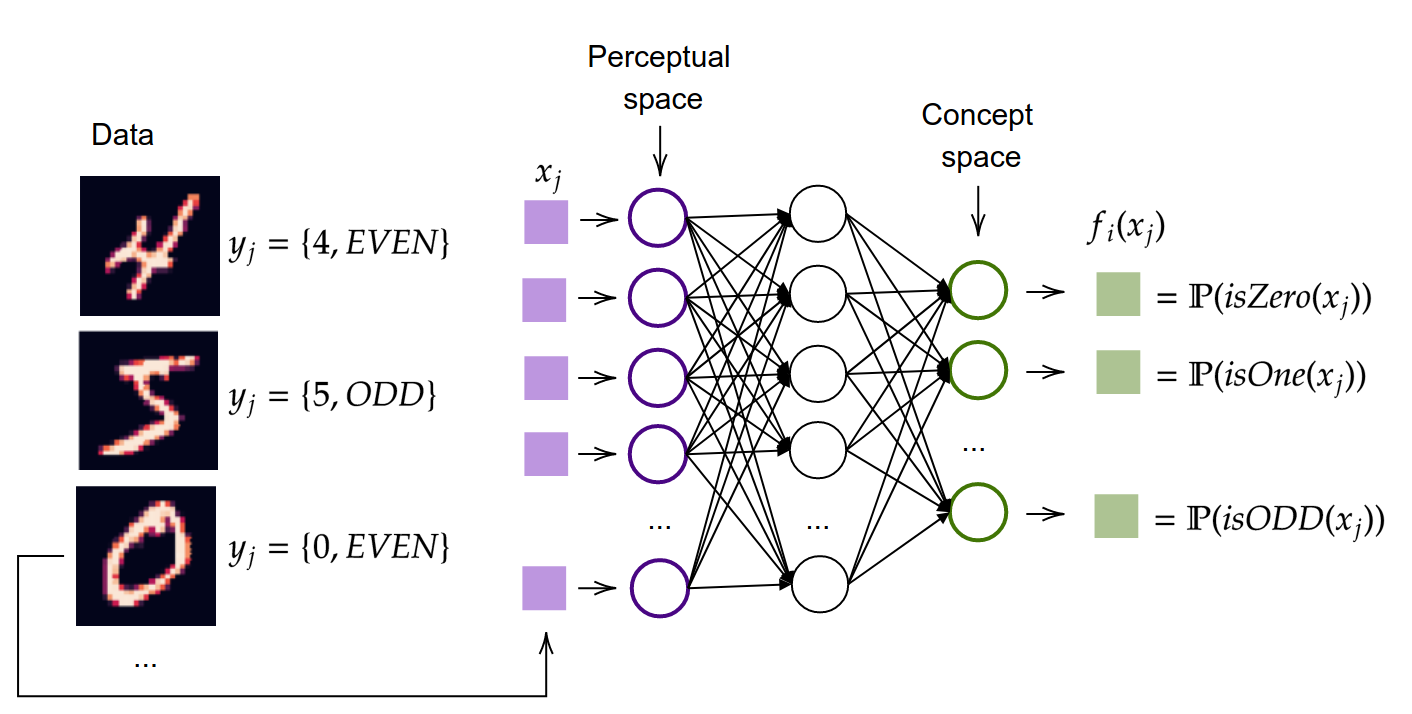

**The general learning objective is to derive the parameters of the task functions (implemented by the neural network) by finding patterns from the perceptual to the concept space.**

The good news is that there is usually **more than one solution** to this problem!
The problem is now: how to choose? Can we find a solution that is more **useful**?


### Humans don't like black boxes
We can reformulate the previous question by considering this specific aspect: **humans don't like black boxes**. Then the new question could be: Is it possible to find a solution that is more interpretable?
However, this question is still ill-posed! We didn't define what *interpretable* means!

One way of thinking about (*scientific*) interpretability is in terms of logic. **A (*scientific*) argument is interpretable from a human standpoint, if it can be described by a limited set of concepts linked by logical rules**. A simple example is the syllogism:

> All men are mortal.
> 
> Socrates is a man.
>
> Therefore, Socrates is mortal.

So, now our problem can be reformulated (again) by asking the question: **how to find a solution that can be represented with logical constraints?**

Unfortunately, exploring the space of all possible solutions might be unfeasible in practice. So, we need to find a strategy to get this solution without searching! One possibility is slightly change (again!!) our research question to: **how to find a solution so that the network is compliant with logical constraints**?
Indeed, if a network learns a complex task and is compliant with logical rules at the same time, we can provide as explanations such logical rules *at least*!

So the problem now is: **how to train a neural network so that it is also compliant with logical constraints**?


### Learning with constraints
We can divide the problem into **3 steps**.

**First**, we need a way to represent human knowledge. How? A simple solution is to represent knowledge by means of [**First Order Logic (FOL)**](https://en.wikipedia.org/wiki/First-order_logic) formulas.
FOL formulas can be defined as strings of symbols representing logical expressions. 
For instance, the statement "Socrates is a man" can be translated as: $\exists x \ s.t. \ isSocrates(x) \wedge isMan(x)$.

**Second**, we need a way to transform FOL formulas into algebraic equations, so that the neural network can process them correctly. How? One possible solution is to convert FOL formulas in fuzzy logic expressions. So, we are changing the domain from ${0,1}$ to $[0,1]$. More specifically, in this notebook we will use the [**product triangular norm (T-norm)**](https://en.wikipedia.org/wiki/T-norm). [This fuzzy logic](https://en.wikipedia.org/wiki/T-norm_fuzzy_logics) allows us to transform conjunctions and negations as follows:
- $\neg f(x) \iff 1-f(x)$
- $f_1(x) \wedge f_2(x) \iff f_1(x) f_2(x)$

So, to use the product T-norm, first we need re-write our formulas using **[De Morgan's laws](https://en.wikipedia.org/wiki/De_Morgan%27s_laws) and the [material implication](https://en.wikipedia.org/wiki/Material_implication_%28rule_of_inference%29)** in order to limit the set of operators to $\{\neg, \wedge\}$ only.
For instance, the formula $\forall x, isHuman(x) \wedge isOld(x) \implies isWise(x)$ can be solved in 4 steps:
- material implication: $\neg (isHuman(x) \wedge isOld(x)) \lor isWise(x)$
- De Morgan's law: $\neg (\neg(\neg(isHuman(x) \wedge isOld(x))) \wedge \neg isWise(x))$
- simplify: $\neg (isHuman(x) \wedge isOld(x) \wedge \neg isWise(x)$
- convert to fuzzy logic (product T-norm): $\phi(x) = 1 - isHuman(x) isOld(x) (1 - isWise(x)) = 1$

**Third**, we need a way to train the network so that it will be compliant with such constraints. How? We can **include our fuzzy constraints in the loss function as a [regularization term](https://en.wikipedia.org/wiki/Regularization_%28mathematics%29)**.
For instance, we can make the network learn the set of constraints $\forall x, \{\phi_1 (f(x)) = 1, \phi_2 (f(x)) = 1\}$ by augmenting the loss function with the term:

$\Phi (f,\mathcal{Z},\mu) = \frac{1}{|\mathcal{Z}|} \sum_{j=1}^{|\mathcal{Z}|} \mu_1 \hat{\phi}_1 (f(x_j)) + \mu_2 \hat{\phi}_2 (f(x_j))$

where $|\mathcal{Z}|$ represents the size of the training set, $\mu_i$ the weight of the $i$-th constraint, and $\hat{\phi}_i = 1 - \phi_i$ the cost of violating the $i$-th constraint.

The general formula for $L$ constraints is:

$\Phi (f,\mathcal{Z},\mu) = \frac{1}{|\mathcal{Z}|} \sum_{j=1}^{|\mathcal{Z}|} \sum_{h=1}^{L} \mu_h \hat{\phi}_h (f(x_j))$

The loss function for a multi-task classification problem can be written as:

$\mathcal{L} = H(\hat{y}, y) + \lambda \Phi (f,\mathcal{Z},\mu)$

where $H$ is the [binary cross-entropy loss function](https://en.wikipedia.org/wiki/Cross_entropy).


## Libraries
First we need to import some useful libraries:

In [69]:
import torch
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Dataset

In this notebook we will use a simplified version of the MNIST dataset called DIGITS. Each sample $x_i$ is an $8 \times 8$-pixels' handritten image representing a digit, while the supervision $y_i$ represents its numeric value.

We can first load the dataset and have a look at some of his properties:

In [70]:
X, y = load_digits(return_X_y=True)

print(f'X shape: {X.shape}\nClasses: {np.unique(y)}')

X shape: (1797, 64)
Classes: [0 1 2 3 4 5 6 7 8 9]


As you can see, the images are flattened in a $64$-length vector, but we can easily visualize samples by reshaping the input:

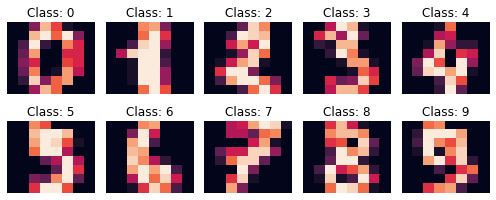

In [71]:
# show the first ten images
figs = X[:10].reshape((10, 8, 8))
plt.figure(figsize=[7, 7])
for i, fig in enumerate(figs):
    plt.subplot(5, 5, i+1)
    plt.title(f'Class: {y[i]}')
    sns.heatmap(fig, cbar=False)
    plt.axis('off')
plt.tight_layout()
plt.show()

As we are framing our problem as a multi-task classification problem, we need to encode our supervisions in a one-hot representation:

In [72]:
enc = OneHotEncoder()
y1h = enc.fit_transform(y.reshape(-1, 1)).toarray()

print(f'Before: {y.shape}\nAfter: {y1h.shape}')

Before: (1797,)
After: (1797, 10)


To make it more fun, we will add two additional task functions: ODD (11-th column) and EVEN (12-th column).

In [73]:
y2 = np.zeros((len(y), 2))
for i, yi in enumerate(y):
    if yi % 2:
        y2[i, 0] = 1
    else:
        y2[i, 1] = 1
y1h2 = np.hstack((y1h, y2))

print(f'Target vector shape: {y1h2.shape}')
for i in range(10):
    print(f'Example ({y[i]}): {y1h2[i]}')

Target vector shape: (1797, 12)
Example (0): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Example (1): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Example (2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Example (3): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
Example (4): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
Example (5): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
Example (6): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
Example (7): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
Example (8): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
Example (9): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]


We are now ready to split our dataset into a training and a test set:

In [74]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y1h2, test_size=0.33, random_state=42)

To make even trickier we will just provide a fixed supervision to the network for the ODD and EVEN task functions. Hence the network will need to 
learn these task functions by relying upon our constraints only!

In [75]:
y_train_np_nan = y_train_np.copy()
y_train_np_nan[:, -2:] = 0.4
y_train_np_nan

array([[0. , 1. , 0. , ..., 0. , 0.4, 0.4],
       [0. , 1. , 0. , ..., 0. , 0.4, 0.4],
       [0. , 0. , 0. , ..., 0. , 0.4, 0.4],
       ...,
       [0. , 0. , 1. , ..., 0. , 0.4, 0.4],
       [0. , 0. , 0. , ..., 0. , 0.4, 0.4],
       [0. , 1. , 0. , ..., 0. , 0.4, 0.4]])

Finally, we need to transoform our data into torch tensors to be processed by the network:

In [76]:
x_train = torch.FloatTensor(X_train_np)
y_train = torch.FloatTensor(y_train_np_nan)
x_test = torch.FloatTensor(X_test_np)
y_test = torch.FloatTensor(y_test_np)

## Network
We will use a very simple (and quite standard) feedforward neural network with three layers, ReLU activations, and $12$ output units (one for each task function) with sigmoid activations. We are not using softmax as in our problem more than one predicate on the task function can be true at the same time (e.g. $isTwo(x)$ and $isEven(x)$ should be true at the same time).

In [77]:
class FeedForwardNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(FeedForwardNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h = self.linear1(x)
        h = torch.nn.functional.relu(h)
        h = self.linear2(h)
        h = torch.nn.functional.relu(h)
        h = self.linear3(h)
        y_pred = torch.sigmoid(h)
        return y_pred

We can now generate an instance of the network:

In [78]:
din, dh, dout = x_train.shape[1], 20, y_train.shape[1]
model = FeedForwardNet(din, dh, dout)

print(model)

FeedForwardNet(
  (linear1): Linear(in_features=64, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=12, bias=True)
)


## Loss function
As presented in the introduction, the loss function is composed of two terms:
- the supervision loss (here the binary cross-entropy loss), and
- the constraint loss

The two losses can be linearly combined:

In [79]:
def BCECLoss(output, targets, constraint_weight):
    sup_loss = supervision_loss(output, targets)
    constr_loss = constraint_loss(output)
    tot_loss = sup_loss + constraint_weight * constr_loss
    return tot_loss, sup_loss, constr_loss

### Supervision loss
Pytorch offers a variety of built-in supervision losses. For multi-task classification a common choice is the binary cross-entropy error function:

In [80]:
def supervision_loss(output, targets):
    return torch.nn.functional.binary_cross_entropy(output, targets, reduction="sum") / len(output)

### Writing logical constraints
In this example, will try to include two types of constraints:
1. parity constraints
2. mutual exclusivity of task functions

An example of a parity constraint is: $isOne(x) \implies isOdd(x)$. This constraint can be converted in his fuzzy representation as:
- material implication: $\neg isOne(x) \lor isOdd(x)$
- De Morgan's law: $\neg (isOne(x) \wedge \neg isOdd(x))$
- convert to fuzzy logic (product T-norm): $\phi(x) = 1 - isOne(x)(1 - isOdd(x)) = 1$
- objective to minimize: $\hat{\phi}(x) = 1 - \phi(x) = isOne(x)(1 - isOdd(x))$

Mutual exclusivity can be enforced both on digit values (e.g. $isZero(x) \ XOR \ isOne(x) \ XOR \ ... \ XOR \ isNine(x)$) and on the parity property, i.e. $isEven(x) \ XOR \ isOdd(x)$. As an example, the mutual exclusivity of EVEN and ODD properties can be written as:
- convertion: $(isEven(x) \wedge \neg isOdd(x)) \lor (\neg isEven(x) \wedge isOdd(x))$
- De Morgan's law: $\neg(\neg(isEven(x) \wedge \neg isOdd(x)) \wedge \neg (\neg isEven(x) \wedge isOdd(x)))$
- simplify: $\neg ((\neg isEven(x) \wedge isOdd(x)) \wedge (isEven(x) \wedge \neg isOdd(x)))$
- convert to fuzzy logic (product T-norm): $\phi(x) = 1 - ((1 - isEven(x)) isOdd(x) isEven(x) (1 - isOdd(x))) = 1$
- objective to minimize: $\hat{\phi}(x) = 1 - \phi(x) = (1 - isEven(x)) isOdd(x) isEven(x) (1 - isOdd(x))$

Similar steps can be used to handle mutual exclusivity on digit predictions.

In [81]:
def constraint_loss(output, mu=10):
    # MAIN CLASSES
    ZERO = output[:, 0]
    ONE = output[:, 1]
    TWO = output[:, 2]
    THREE = output[:, 3]
    FOUR = output[:, 4]
    FIVE = output[:, 5]
    SIX = output[:, 6]
    SEVEN = output[:, 7]
    EIGHT = output[:, 8]
    NINE = output[:, 9]

    # ATTRIBUTE CLASSES
    ODD = output[:, 10]
    EVEN = output[:, 11]

    # here we converted each FOL rule using the product T-Norm (no-residual)
    loss_fol_product_tnorm = [
        # N(1,3,5,7,9) => ODD
        mu * (ONE * (1. - ODD)),
        mu * (THREE * (1. - ODD)),
        mu * (FIVE * (1. - ODD)),
        mu * (SEVEN * (1. - ODD)),
        mu * (NINE * (1. - ODD)),

        # N(0,2,4,6,8) => EVEN
        mu * (ZERO * (1. - EVEN)),
        mu * (TWO * (1. - EVEN)),
        mu * (FOUR * (1. - EVEN)),
        mu * (SIX * (1. - EVEN)),
        mu * (EIGHT * (1. - EVEN)),

        # XOR ON THE MAIN CLASSES
        mu * (
                (1 - ((ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (
                            1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (
                            1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (
                            1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (
                            1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (FOUR) * (1 - FIVE) * (1 - SIX) * (
                            1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (FIVE) * (1 - SIX) * (
                            1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (SIX) * (
                            1 - SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (
                    SEVEN) * (1 - EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (
                            1 - SEVEN) * (EIGHT) * (1 - NINE))) *
                (1 - ((1 - ZERO) * (1 - ONE) * (1 - TWO) * (1 - THREE) * (1 - FOUR) * (1 - FIVE) * (1 - SIX) * (
                            1 - SEVEN) * (1 - EIGHT) * (NINE)))
        ),
        
        # XOR ON THE ATTRIBUTE CLASSES
        10 * mu * (
                (EVEN) * (1 - ODD) *
                (1 - EVEN) * (ODD)
        ),
    ]

    losses = torch.sum(torch.stack(loss_fol_product_tnorm, dim=0), dim=1)
    constr_loss = torch.squeeze(torch.sum(losses, dim=0)) / len(output)
    return constr_loss

## Train loop
The train loop is quite standard:

In [82]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
epoch = 2000
for epoch in range(epoch):
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(x_train)

    # Compute Loss
    tot_loss, sup_loss, constr_loss = BCECLoss(y_pred, y_train, constraint_weight=0.1)

    # compute accuracy
    y_pred_d = (y_pred > 0.5).detach().numpy()
    accuracy = ((y_pred_d[:, :-2] == y_train_np[:, :-2]).sum(axis=1) == y_train_np[:, :-2].shape[1]).mean()
    accuracy2 = ((y_pred_d == y_train_np).sum(axis=1) == y_train_np.shape[1]).mean()

    print(f'Epoch {epoch + 1}: '
          f'loss: {tot_loss.item():.4f} '
          f'| supervision loss: {sup_loss.item():.4f} '
          f'| constraint loss: {constr_loss.item():.4f} '
          f'| accuracy: {accuracy:.4f} '
          f'| acc2: {accuracy2:.4f}')

    # Backward pass
    tot_loss.backward()
    optimizer.step()

Epoch 1: loss: 13.4059 | supervision loss: 9.8556 | constraint loss: 35.5034 | accuracy: 0.0000 | acc2: 0.0000
Epoch 2: loss: 11.0121 | supervision loss: 7.8825 | constraint loss: 31.2957 | accuracy: 0.0025 | acc2: 0.0000
Epoch 3: loss: 9.3465 | supervision loss: 7.4155 | constraint loss: 19.3098 | accuracy: 0.0100 | acc2: 0.0000
Epoch 4: loss: 8.2413 | supervision loss: 7.0766 | constraint loss: 11.6475 | accuracy: 0.0998 | acc2: 0.0000
Epoch 5: loss: 7.5204 | supervision loss: 6.6173 | constraint loss: 9.0307 | accuracy: 0.0075 | acc2: 0.0000
Epoch 6: loss: 7.0570 | supervision loss: 6.0819 | constraint loss: 9.7509 | accuracy: 0.0000 | acc2: 0.0000
Epoch 7: loss: 6.7772 | supervision loss: 5.5015 | constraint loss: 12.7570 | accuracy: 0.0000 | acc2: 0.0000
Epoch 8: loss: 6.6279 | supervision loss: 5.0776 | constraint loss: 15.5035 | accuracy: 0.0000 | acc2: 0.0000
Epoch 9: loss: 6.4642 | supervision loss: 4.8307 | constraint loss: 16.3341 | accuracy: 0.0000 | acc2: 0.0000
Epoch 10: 

Epoch 78: loss: 2.9359 | supervision loss: 2.0340 | constraint loss: 9.0185 | accuracy: 0.8903 | acc2: 0.7365
Epoch 79: loss: 2.9179 | supervision loss: 2.0183 | constraint loss: 8.9956 | accuracy: 0.8894 | acc2: 0.7340
Epoch 80: loss: 2.9005 | supervision loss: 2.0063 | constraint loss: 8.9419 | accuracy: 0.8944 | acc2: 0.7431
Epoch 81: loss: 2.8837 | supervision loss: 1.9982 | constraint loss: 8.8555 | accuracy: 0.8969 | acc2: 0.7473
Epoch 82: loss: 2.8677 | supervision loss: 1.9905 | constraint loss: 8.7725 | accuracy: 0.9002 | acc2: 0.7564
Epoch 83: loss: 2.8527 | supervision loss: 1.9819 | constraint loss: 8.7075 | accuracy: 0.9052 | acc2: 0.7656
Epoch 84: loss: 2.8388 | supervision loss: 1.9730 | constraint loss: 8.6576 | accuracy: 0.9086 | acc2: 0.7706
Epoch 85: loss: 2.8258 | supervision loss: 1.9625 | constraint loss: 8.6329 | accuracy: 0.9102 | acc2: 0.7764
Epoch 86: loss: 2.8137 | supervision loss: 1.9499 | constraint loss: 8.6379 | accuracy: 0.9144 | acc2: 0.7822
Epoch 87: 

Epoch 153: loss: 2.5067 | supervision loss: 1.7643 | constraint loss: 7.4235 | accuracy: 0.9726 | acc2: 0.8786
Epoch 154: loss: 2.5047 | supervision loss: 1.7631 | constraint loss: 7.4153 | accuracy: 0.9726 | acc2: 0.8778
Epoch 155: loss: 2.5027 | supervision loss: 1.7617 | constraint loss: 7.4101 | accuracy: 0.9717 | acc2: 0.8770
Epoch 156: loss: 2.5007 | supervision loss: 1.7593 | constraint loss: 7.4142 | accuracy: 0.9717 | acc2: 0.8778
Epoch 157: loss: 2.4988 | supervision loss: 1.7582 | constraint loss: 7.4067 | accuracy: 0.9726 | acc2: 0.8795
Epoch 158: loss: 2.4969 | supervision loss: 1.7569 | constraint loss: 7.3998 | accuracy: 0.9734 | acc2: 0.8811
Epoch 159: loss: 2.4950 | supervision loss: 1.7549 | constraint loss: 7.4015 | accuracy: 0.9717 | acc2: 0.8795
Epoch 160: loss: 2.4932 | supervision loss: 1.7547 | constraint loss: 7.3848 | accuracy: 0.9717 | acc2: 0.8811
Epoch 161: loss: 2.4914 | supervision loss: 1.7542 | constraint loss: 7.3722 | accuracy: 0.9717 | acc2: 0.8803
E

Epoch 228: loss: 2.4044 | supervision loss: 1.6938 | constraint loss: 7.1065 | accuracy: 0.9942 | acc2: 0.9127
Epoch 229: loss: 2.4037 | supervision loss: 1.6897 | constraint loss: 7.1400 | accuracy: 0.9925 | acc2: 0.9160
Epoch 230: loss: 2.4029 | supervision loss: 1.6929 | constraint loss: 7.0996 | accuracy: 0.9933 | acc2: 0.9127
Epoch 231: loss: 2.4019 | supervision loss: 1.6885 | constraint loss: 7.1340 | accuracy: 0.9925 | acc2: 0.9169
Epoch 232: loss: 2.4006 | supervision loss: 1.6911 | constraint loss: 7.0951 | accuracy: 0.9942 | acc2: 0.9152
Epoch 233: loss: 2.3994 | supervision loss: 1.6882 | constraint loss: 7.1125 | accuracy: 0.9942 | acc2: 0.9194
Epoch 234: loss: 2.3982 | supervision loss: 1.6895 | constraint loss: 7.0876 | accuracy: 0.9942 | acc2: 0.9160
Epoch 235: loss: 2.3974 | supervision loss: 1.6885 | constraint loss: 7.0890 | accuracy: 0.9950 | acc2: 0.9177
Epoch 236: loss: 2.3967 | supervision loss: 1.6866 | constraint loss: 7.1008 | accuracy: 0.9950 | acc2: 0.9202
E

Epoch 303: loss: 2.3580 | supervision loss: 1.6689 | constraint loss: 6.8908 | accuracy: 0.9975 | acc2: 0.9268
Epoch 304: loss: 2.3576 | supervision loss: 1.6682 | constraint loss: 6.8935 | accuracy: 0.9975 | acc2: 0.9285
Epoch 305: loss: 2.3572 | supervision loss: 1.6674 | constraint loss: 6.8973 | accuracy: 0.9975 | acc2: 0.9285
Epoch 306: loss: 2.3570 | supervision loss: 1.6660 | constraint loss: 6.9095 | accuracy: 0.9975 | acc2: 0.9310
Epoch 307: loss: 2.3570 | supervision loss: 1.6688 | constraint loss: 6.8819 | accuracy: 0.9983 | acc2: 0.9293
Epoch 308: loss: 2.3572 | supervision loss: 1.6677 | constraint loss: 6.8949 | accuracy: 0.9975 | acc2: 0.9285
Epoch 309: loss: 2.3580 | supervision loss: 1.6703 | constraint loss: 6.8772 | accuracy: 0.9983 | acc2: 0.9293
Epoch 310: loss: 2.3598 | supervision loss: 1.6662 | constraint loss: 6.9362 | accuracy: 0.9975 | acc2: 0.9310
Epoch 311: loss: 2.3626 | supervision loss: 1.6731 | constraint loss: 6.8951 | accuracy: 0.9983 | acc2: 0.9268
E

Epoch 378: loss: 2.3457 | supervision loss: 1.6640 | constraint loss: 6.8167 | accuracy: 0.9992 | acc2: 0.9335
Epoch 379: loss: 2.3424 | supervision loss: 1.6553 | constraint loss: 6.8718 | accuracy: 0.9992 | acc2: 0.9377
Epoch 380: loss: 2.3385 | supervision loss: 1.6578 | constraint loss: 6.8072 | accuracy: 0.9992 | acc2: 0.9360
Epoch 381: loss: 2.3368 | supervision loss: 1.6602 | constraint loss: 6.7666 | accuracy: 0.9992 | acc2: 0.9385
Epoch 382: loss: 2.3379 | supervision loss: 1.6634 | constraint loss: 6.7450 | accuracy: 0.9992 | acc2: 0.9410
Epoch 383: loss: 2.3403 | supervision loss: 1.6673 | constraint loss: 6.7301 | accuracy: 0.9992 | acc2: 0.9335
Epoch 384: loss: 2.3419 | supervision loss: 1.6606 | constraint loss: 6.8134 | accuracy: 0.9992 | acc2: 0.9360
Epoch 385: loss: 2.3409 | supervision loss: 1.6610 | constraint loss: 6.7988 | accuracy: 0.9992 | acc2: 0.9327
Epoch 386: loss: 2.3381 | supervision loss: 1.6551 | constraint loss: 6.8299 | accuracy: 0.9992 | acc2: 0.9385
E

Epoch 453: loss: 2.3274 | supervision loss: 1.6605 | constraint loss: 6.6688 | accuracy: 1.0000 | acc2: 0.9401
Epoch 454: loss: 2.3279 | supervision loss: 1.6605 | constraint loss: 6.6738 | accuracy: 1.0000 | acc2: 0.9476
Epoch 455: loss: 2.3275 | supervision loss: 1.6622 | constraint loss: 6.6533 | accuracy: 1.0000 | acc2: 0.9401
Epoch 456: loss: 2.3266 | supervision loss: 1.6576 | constraint loss: 6.6898 | accuracy: 1.0000 | acc2: 0.9476
Epoch 457: loss: 2.3257 | supervision loss: 1.6561 | constraint loss: 6.6957 | accuracy: 1.0000 | acc2: 0.9443
Epoch 458: loss: 2.3253 | supervision loss: 1.6546 | constraint loss: 6.7066 | accuracy: 1.0000 | acc2: 0.9451
Epoch 459: loss: 2.3254 | supervision loss: 1.6553 | constraint loss: 6.7004 | accuracy: 1.0000 | acc2: 0.9476
Epoch 460: loss: 2.3257 | supervision loss: 1.6584 | constraint loss: 6.6731 | accuracy: 1.0000 | acc2: 0.9426
Epoch 461: loss: 2.3260 | supervision loss: 1.6588 | constraint loss: 6.6725 | accuracy: 1.0000 | acc2: 0.9493
E

Epoch 527: loss: 2.3198 | supervision loss: 1.6552 | constraint loss: 6.6452 | accuracy: 1.0000 | acc2: 0.9510
Epoch 528: loss: 2.3194 | supervision loss: 1.6551 | constraint loss: 6.6429 | accuracy: 1.0000 | acc2: 0.9510
Epoch 529: loss: 2.3193 | supervision loss: 1.6563 | constraint loss: 6.6303 | accuracy: 1.0000 | acc2: 0.9518
Epoch 530: loss: 2.3195 | supervision loss: 1.6579 | constraint loss: 6.6157 | accuracy: 1.0000 | acc2: 0.9510
Epoch 531: loss: 2.3197 | supervision loss: 1.6604 | constraint loss: 6.5936 | accuracy: 1.0000 | acc2: 0.9501
Epoch 532: loss: 2.3199 | supervision loss: 1.6595 | constraint loss: 6.6043 | accuracy: 1.0000 | acc2: 0.9518
Epoch 533: loss: 2.3199 | supervision loss: 1.6599 | constraint loss: 6.6004 | accuracy: 1.0000 | acc2: 0.9493
Epoch 534: loss: 2.3198 | supervision loss: 1.6572 | constraint loss: 6.6262 | accuracy: 1.0000 | acc2: 0.9518
Epoch 535: loss: 2.3195 | supervision loss: 1.6572 | constraint loss: 6.6232 | accuracy: 1.0000 | acc2: 0.9501
E

Epoch 603: loss: 2.3190 | supervision loss: 1.6576 | constraint loss: 6.6133 | accuracy: 1.0000 | acc2: 0.9559
Epoch 604: loss: 2.3182 | supervision loss: 1.6597 | constraint loss: 6.5854 | accuracy: 1.0000 | acc2: 0.9534
Epoch 605: loss: 2.3174 | supervision loss: 1.6577 | constraint loss: 6.5961 | accuracy: 1.0000 | acc2: 0.9543
Epoch 606: loss: 2.3165 | supervision loss: 1.6595 | constraint loss: 6.5698 | accuracy: 1.0000 | acc2: 0.9534
Epoch 607: loss: 2.3158 | supervision loss: 1.6585 | constraint loss: 6.5724 | accuracy: 1.0000 | acc2: 0.9534
Epoch 608: loss: 2.3153 | supervision loss: 1.6593 | constraint loss: 6.5604 | accuracy: 1.0000 | acc2: 0.9526
Epoch 609: loss: 2.3152 | supervision loss: 1.6591 | constraint loss: 6.5609 | accuracy: 1.0000 | acc2: 0.9526
Epoch 610: loss: 2.3152 | supervision loss: 1.6589 | constraint loss: 6.5631 | accuracy: 1.0000 | acc2: 0.9534
Epoch 611: loss: 2.3154 | supervision loss: 1.6595 | constraint loss: 6.5589 | accuracy: 1.0000 | acc2: 0.9534
E

Epoch 678: loss: 2.3128 | supervision loss: 1.6600 | constraint loss: 6.5281 | accuracy: 1.0000 | acc2: 0.9559
Epoch 679: loss: 2.3127 | supervision loss: 1.6597 | constraint loss: 6.5298 | accuracy: 1.0000 | acc2: 0.9559
Epoch 680: loss: 2.3126 | supervision loss: 1.6600 | constraint loss: 6.5262 | accuracy: 1.0000 | acc2: 0.9559
Epoch 681: loss: 2.3126 | supervision loss: 1.6598 | constraint loss: 6.5274 | accuracy: 1.0000 | acc2: 0.9559
Epoch 682: loss: 2.3125 | supervision loss: 1.6599 | constraint loss: 6.5264 | accuracy: 1.0000 | acc2: 0.9559
Epoch 683: loss: 2.3125 | supervision loss: 1.6597 | constraint loss: 6.5284 | accuracy: 1.0000 | acc2: 0.9559
Epoch 684: loss: 2.3125 | supervision loss: 1.6597 | constraint loss: 6.5276 | accuracy: 1.0000 | acc2: 0.9559
Epoch 685: loss: 2.3124 | supervision loss: 1.6596 | constraint loss: 6.5285 | accuracy: 1.0000 | acc2: 0.9559
Epoch 686: loss: 2.3124 | supervision loss: 1.6599 | constraint loss: 6.5254 | accuracy: 1.0000 | acc2: 0.9559
E

Epoch 752: loss: 2.3106 | supervision loss: 1.6623 | constraint loss: 6.4822 | accuracy: 1.0000 | acc2: 0.9609
Epoch 753: loss: 2.3105 | supervision loss: 1.6619 | constraint loss: 6.4865 | accuracy: 1.0000 | acc2: 0.9609
Epoch 754: loss: 2.3105 | supervision loss: 1.6614 | constraint loss: 6.4912 | accuracy: 1.0000 | acc2: 0.9609
Epoch 755: loss: 2.3104 | supervision loss: 1.6605 | constraint loss: 6.4988 | accuracy: 1.0000 | acc2: 0.9609
Epoch 756: loss: 2.3104 | supervision loss: 1.6606 | constraint loss: 6.4973 | accuracy: 1.0000 | acc2: 0.9609
Epoch 757: loss: 2.3103 | supervision loss: 1.6608 | constraint loss: 6.4947 | accuracy: 1.0000 | acc2: 0.9609
Epoch 758: loss: 2.3102 | supervision loss: 1.6613 | constraint loss: 6.4890 | accuracy: 1.0000 | acc2: 0.9601
Epoch 759: loss: 2.3102 | supervision loss: 1.6616 | constraint loss: 6.4860 | accuracy: 1.0000 | acc2: 0.9601
Epoch 760: loss: 2.3102 | supervision loss: 1.6617 | constraint loss: 6.4845 | accuracy: 1.0000 | acc2: 0.9601
E

Epoch 826: loss: 2.3095 | supervision loss: 1.6631 | constraint loss: 6.4641 | accuracy: 1.0000 | acc2: 0.9634
Epoch 827: loss: 2.3100 | supervision loss: 1.6630 | constraint loss: 6.4704 | accuracy: 1.0000 | acc2: 0.9618
Epoch 828: loss: 2.3108 | supervision loss: 1.6637 | constraint loss: 6.4702 | accuracy: 1.0000 | acc2: 0.9634
Epoch 829: loss: 2.3118 | supervision loss: 1.6635 | constraint loss: 6.4832 | accuracy: 1.0000 | acc2: 0.9609
Epoch 830: loss: 2.3130 | supervision loss: 1.6644 | constraint loss: 6.4866 | accuracy: 1.0000 | acc2: 0.9609
Epoch 831: loss: 2.3144 | supervision loss: 1.6637 | constraint loss: 6.5067 | accuracy: 1.0000 | acc2: 0.9593
Epoch 832: loss: 2.3153 | supervision loss: 1.6642 | constraint loss: 6.5112 | accuracy: 1.0000 | acc2: 0.9618
Epoch 833: loss: 2.3154 | supervision loss: 1.6625 | constraint loss: 6.5288 | accuracy: 1.0000 | acc2: 0.9609
Epoch 834: loss: 2.3141 | supervision loss: 1.6623 | constraint loss: 6.5189 | accuracy: 1.0000 | acc2: 0.9609
E

Epoch 907: loss: 2.3100 | supervision loss: 1.6637 | constraint loss: 6.4631 | accuracy: 1.0000 | acc2: 0.9659
Epoch 908: loss: 2.3090 | supervision loss: 1.6634 | constraint loss: 6.4559 | accuracy: 1.0000 | acc2: 0.9618
Epoch 909: loss: 2.3080 | supervision loss: 1.6638 | constraint loss: 6.4423 | accuracy: 1.0000 | acc2: 0.9667
Epoch 910: loss: 2.3072 | supervision loss: 1.6640 | constraint loss: 6.4313 | accuracy: 1.0000 | acc2: 0.9634
Epoch 911: loss: 2.3066 | supervision loss: 1.6644 | constraint loss: 6.4222 | accuracy: 1.0000 | acc2: 0.9659
Epoch 912: loss: 2.3064 | supervision loss: 1.6645 | constraint loss: 6.4186 | accuracy: 1.0000 | acc2: 0.9651
Epoch 913: loss: 2.3064 | supervision loss: 1.6645 | constraint loss: 6.4190 | accuracy: 1.0000 | acc2: 0.9651
Epoch 914: loss: 2.3066 | supervision loss: 1.6644 | constraint loss: 6.4216 | accuracy: 1.0000 | acc2: 0.9667
Epoch 915: loss: 2.3069 | supervision loss: 1.6643 | constraint loss: 6.4254 | accuracy: 1.0000 | acc2: 0.9651
E

Epoch 984: loss: 2.3070 | supervision loss: 1.6655 | constraint loss: 6.4152 | accuracy: 1.0000 | acc2: 0.9634
Epoch 985: loss: 2.3066 | supervision loss: 1.6655 | constraint loss: 6.4113 | accuracy: 1.0000 | acc2: 0.9676
Epoch 986: loss: 2.3062 | supervision loss: 1.6655 | constraint loss: 6.4070 | accuracy: 1.0000 | acc2: 0.9651
Epoch 987: loss: 2.3058 | supervision loss: 1.6652 | constraint loss: 6.4059 | accuracy: 1.0000 | acc2: 0.9667
Epoch 988: loss: 2.3055 | supervision loss: 1.6652 | constraint loss: 6.4031 | accuracy: 1.0000 | acc2: 0.9643
Epoch 989: loss: 2.3052 | supervision loss: 1.6651 | constraint loss: 6.4013 | accuracy: 1.0000 | acc2: 0.9676
Epoch 990: loss: 2.3050 | supervision loss: 1.6653 | constraint loss: 6.3975 | accuracy: 1.0000 | acc2: 0.9651
Epoch 991: loss: 2.3049 | supervision loss: 1.6654 | constraint loss: 6.3950 | accuracy: 1.0000 | acc2: 0.9676
Epoch 992: loss: 2.3048 | supervision loss: 1.6655 | constraint loss: 6.3931 | accuracy: 1.0000 | acc2: 0.9667
E

Epoch 1072: loss: 2.3062 | supervision loss: 1.6664 | constraint loss: 6.3983 | accuracy: 1.0000 | acc2: 0.9709
Epoch 1073: loss: 2.3061 | supervision loss: 1.6666 | constraint loss: 6.3955 | accuracy: 1.0000 | acc2: 0.9643
Epoch 1074: loss: 2.3059 | supervision loss: 1.6657 | constraint loss: 6.4015 | accuracy: 1.0000 | acc2: 0.9709
Epoch 1075: loss: 2.3055 | supervision loss: 1.6662 | constraint loss: 6.3926 | accuracy: 1.0000 | acc2: 0.9651
Epoch 1076: loss: 2.3049 | supervision loss: 1.6659 | constraint loss: 6.3906 | accuracy: 1.0000 | acc2: 0.9701
Epoch 1077: loss: 2.3044 | supervision loss: 1.6665 | constraint loss: 6.3789 | accuracy: 1.0000 | acc2: 0.9676
Epoch 1078: loss: 2.3040 | supervision loss: 1.6664 | constraint loss: 6.3756 | accuracy: 1.0000 | acc2: 0.9692
Epoch 1079: loss: 2.3037 | supervision loss: 1.6668 | constraint loss: 6.3689 | accuracy: 1.0000 | acc2: 0.9684
Epoch 1080: loss: 2.3035 | supervision loss: 1.6667 | constraint loss: 6.3676 | accuracy: 1.0000 | acc2:

Epoch 1149: loss: 2.3025 | supervision loss: 1.6677 | constraint loss: 6.3478 | accuracy: 1.0000 | acc2: 0.9701
Epoch 1150: loss: 2.3027 | supervision loss: 1.6673 | constraint loss: 6.3533 | accuracy: 1.0000 | acc2: 0.9717
Epoch 1151: loss: 2.3029 | supervision loss: 1.6678 | constraint loss: 6.3501 | accuracy: 1.0000 | acc2: 0.9692
Epoch 1152: loss: 2.3031 | supervision loss: 1.6675 | constraint loss: 6.3562 | accuracy: 1.0000 | acc2: 0.9717
Epoch 1153: loss: 2.3034 | supervision loss: 1.6682 | constraint loss: 6.3518 | accuracy: 1.0000 | acc2: 0.9684
Epoch 1154: loss: 2.3039 | supervision loss: 1.6677 | constraint loss: 6.3617 | accuracy: 1.0000 | acc2: 0.9717
Epoch 1155: loss: 2.3044 | supervision loss: 1.6685 | constraint loss: 6.3582 | accuracy: 1.0000 | acc2: 0.9684
Epoch 1156: loss: 2.3050 | supervision loss: 1.6677 | constraint loss: 6.3725 | accuracy: 1.0000 | acc2: 0.9717
Epoch 1157: loss: 2.3056 | supervision loss: 1.6687 | constraint loss: 6.3688 | accuracy: 1.0000 | acc2:

Epoch 1231: loss: 2.3009 | supervision loss: 1.6687 | constraint loss: 6.3220 | accuracy: 1.0000 | acc2: 0.9734
Epoch 1232: loss: 2.3010 | supervision loss: 1.6685 | constraint loss: 6.3245 | accuracy: 1.0000 | acc2: 0.9734
Epoch 1233: loss: 2.3010 | supervision loss: 1.6688 | constraint loss: 6.3219 | accuracy: 1.0000 | acc2: 0.9734
Epoch 1234: loss: 2.3011 | supervision loss: 1.6688 | constraint loss: 6.3223 | accuracy: 1.0000 | acc2: 0.9742
Epoch 1235: loss: 2.3012 | supervision loss: 1.6693 | constraint loss: 6.3183 | accuracy: 1.0000 | acc2: 0.9726
Epoch 1236: loss: 2.3013 | supervision loss: 1.6689 | constraint loss: 6.3238 | accuracy: 1.0000 | acc2: 0.9742
Epoch 1237: loss: 2.3016 | supervision loss: 1.6693 | constraint loss: 6.3227 | accuracy: 1.0000 | acc2: 0.9701
Epoch 1238: loss: 2.3019 | supervision loss: 1.6687 | constraint loss: 6.3322 | accuracy: 1.0000 | acc2: 0.9734
Epoch 1239: loss: 2.3024 | supervision loss: 1.6696 | constraint loss: 6.3280 | accuracy: 1.0000 | acc2:

Epoch 1309: loss: 2.3085 | supervision loss: 1.6706 | constraint loss: 6.3783 | accuracy: 1.0000 | acc2: 0.9792
Epoch 1310: loss: 2.3103 | supervision loss: 1.6714 | constraint loss: 6.3889 | accuracy: 1.0000 | acc2: 0.9659
Epoch 1311: loss: 2.3107 | supervision loss: 1.6688 | constraint loss: 6.4187 | accuracy: 1.0000 | acc2: 0.9800
Epoch 1312: loss: 2.3085 | supervision loss: 1.6679 | constraint loss: 6.4055 | accuracy: 1.0000 | acc2: 0.9676
Epoch 1313: loss: 2.3050 | supervision loss: 1.6658 | constraint loss: 6.3917 | accuracy: 1.0000 | acc2: 0.9776
Epoch 1314: loss: 2.3016 | supervision loss: 1.6677 | constraint loss: 6.3389 | accuracy: 1.0000 | acc2: 0.9717
Epoch 1315: loss: 2.2999 | supervision loss: 1.6698 | constraint loss: 6.3011 | accuracy: 1.0000 | acc2: 0.9742
Epoch 1316: loss: 2.3000 | supervision loss: 1.6716 | constraint loss: 6.2843 | accuracy: 1.0000 | acc2: 0.9742
Epoch 1317: loss: 2.3014 | supervision loss: 1.6724 | constraint loss: 6.2908 | accuracy: 1.0000 | acc2:

Epoch 1385: loss: 2.3008 | supervision loss: 1.6704 | constraint loss: 6.3040 | accuracy: 1.0000 | acc2: 0.9742
Epoch 1386: loss: 2.3002 | supervision loss: 1.6699 | constraint loss: 6.3031 | accuracy: 1.0000 | acc2: 0.9776
Epoch 1387: loss: 2.2997 | supervision loss: 1.6707 | constraint loss: 6.2898 | accuracy: 1.0000 | acc2: 0.9742
Epoch 1388: loss: 2.2992 | supervision loss: 1.6706 | constraint loss: 6.2858 | accuracy: 1.0000 | acc2: 0.9767
Epoch 1389: loss: 2.2989 | supervision loss: 1.6712 | constraint loss: 6.2769 | accuracy: 1.0000 | acc2: 0.9742
Epoch 1390: loss: 2.2988 | supervision loss: 1.6711 | constraint loss: 6.2767 | accuracy: 1.0000 | acc2: 0.9751
Epoch 1391: loss: 2.2987 | supervision loss: 1.6709 | constraint loss: 6.2786 | accuracy: 1.0000 | acc2: 0.9751
Epoch 1392: loss: 2.2988 | supervision loss: 1.6707 | constraint loss: 6.2804 | accuracy: 1.0000 | acc2: 0.9742
Epoch 1393: loss: 2.2989 | supervision loss: 1.6706 | constraint loss: 6.2826 | accuracy: 1.0000 | acc2:

Epoch 1464: loss: 2.2997 | supervision loss: 1.6714 | constraint loss: 6.2838 | accuracy: 1.0000 | acc2: 0.9817
Epoch 1465: loss: 2.3002 | supervision loss: 1.6722 | constraint loss: 6.2798 | accuracy: 1.0000 | acc2: 0.9759
Epoch 1466: loss: 2.3007 | supervision loss: 1.6712 | constraint loss: 6.2958 | accuracy: 1.0000 | acc2: 0.9842
Epoch 1467: loss: 2.3012 | supervision loss: 1.6722 | constraint loss: 6.2898 | accuracy: 1.0000 | acc2: 0.9751
Epoch 1468: loss: 2.3015 | supervision loss: 1.6710 | constraint loss: 6.3052 | accuracy: 1.0000 | acc2: 0.9842
Epoch 1469: loss: 2.3015 | supervision loss: 1.6720 | constraint loss: 6.2944 | accuracy: 1.0000 | acc2: 0.9751
Epoch 1470: loss: 2.3013 | supervision loss: 1.6707 | constraint loss: 6.3056 | accuracy: 1.0000 | acc2: 0.9842
Epoch 1471: loss: 2.3007 | supervision loss: 1.6716 | constraint loss: 6.2902 | accuracy: 1.0000 | acc2: 0.9767
Epoch 1472: loss: 2.3000 | supervision loss: 1.6705 | constraint loss: 6.2945 | accuracy: 1.0000 | acc2:

Epoch 1542: loss: 2.2967 | supervision loss: 1.6729 | constraint loss: 6.2381 | accuracy: 1.0000 | acc2: 0.9817
Epoch 1543: loss: 2.2968 | supervision loss: 1.6731 | constraint loss: 6.2368 | accuracy: 1.0000 | acc2: 0.9784
Epoch 1544: loss: 2.2969 | supervision loss: 1.6723 | constraint loss: 6.2457 | accuracy: 1.0000 | acc2: 0.9834
Epoch 1545: loss: 2.2970 | supervision loss: 1.6729 | constraint loss: 6.2419 | accuracy: 1.0000 | acc2: 0.9784
Epoch 1546: loss: 2.2973 | supervision loss: 1.6726 | constraint loss: 6.2470 | accuracy: 1.0000 | acc2: 0.9850
Epoch 1547: loss: 2.2976 | supervision loss: 1.6738 | constraint loss: 6.2380 | accuracy: 1.0000 | acc2: 0.9784
Epoch 1548: loss: 2.2980 | supervision loss: 1.6730 | constraint loss: 6.2501 | accuracy: 1.0000 | acc2: 0.9850
Epoch 1549: loss: 2.2986 | supervision loss: 1.6740 | constraint loss: 6.2464 | accuracy: 1.0000 | acc2: 0.9784
Epoch 1550: loss: 2.2994 | supervision loss: 1.6725 | constraint loss: 6.2690 | accuracy: 1.0000 | acc2:

Epoch 1619: loss: 2.2968 | supervision loss: 1.6754 | constraint loss: 6.2136 | accuracy: 1.0000 | acc2: 0.9834
Epoch 1620: loss: 2.2977 | supervision loss: 1.6734 | constraint loss: 6.2427 | accuracy: 1.0000 | acc2: 0.9850
Epoch 1621: loss: 2.2983 | supervision loss: 1.6753 | constraint loss: 6.2298 | accuracy: 1.0000 | acc2: 0.9817
Epoch 1622: loss: 2.2988 | supervision loss: 1.6732 | constraint loss: 6.2553 | accuracy: 1.0000 | acc2: 0.9867
Epoch 1623: loss: 2.2987 | supervision loss: 1.6754 | constraint loss: 6.2325 | accuracy: 1.0000 | acc2: 0.9800
Epoch 1624: loss: 2.2983 | supervision loss: 1.6729 | constraint loss: 6.2543 | accuracy: 1.0000 | acc2: 0.9850
Epoch 1625: loss: 2.2976 | supervision loss: 1.6739 | constraint loss: 6.2364 | accuracy: 1.0000 | acc2: 0.9825
Epoch 1626: loss: 2.2968 | supervision loss: 1.6720 | constraint loss: 6.2477 | accuracy: 1.0000 | acc2: 0.9850
Epoch 1627: loss: 2.2961 | supervision loss: 1.6732 | constraint loss: 6.2287 | accuracy: 1.0000 | acc2:

Epoch 1697: loss: 2.2969 | supervision loss: 1.6760 | constraint loss: 6.2091 | accuracy: 1.0000 | acc2: 0.9842
Epoch 1698: loss: 2.2971 | supervision loss: 1.6738 | constraint loss: 6.2337 | accuracy: 1.0000 | acc2: 0.9875
Epoch 1699: loss: 2.2972 | supervision loss: 1.6764 | constraint loss: 6.2080 | accuracy: 1.0000 | acc2: 0.9834
Epoch 1700: loss: 2.2972 | supervision loss: 1.6735 | constraint loss: 6.2373 | accuracy: 1.0000 | acc2: 0.9875
Epoch 1701: loss: 2.2970 | supervision loss: 1.6755 | constraint loss: 6.2146 | accuracy: 1.0000 | acc2: 0.9834
Epoch 1702: loss: 2.2967 | supervision loss: 1.6730 | constraint loss: 6.2362 | accuracy: 1.0000 | acc2: 0.9875
Epoch 1703: loss: 2.2961 | supervision loss: 1.6755 | constraint loss: 6.2069 | accuracy: 1.0000 | acc2: 0.9859
Epoch 1704: loss: 2.2956 | supervision loss: 1.6741 | constraint loss: 6.2150 | accuracy: 1.0000 | acc2: 0.9859
Epoch 1705: loss: 2.2952 | supervision loss: 1.6759 | constraint loss: 6.1924 | accuracy: 1.0000 | acc2:

Epoch 1775: loss: 2.2947 | supervision loss: 1.6774 | constraint loss: 6.1736 | accuracy: 1.0000 | acc2: 0.9875
Epoch 1776: loss: 2.2952 | supervision loss: 1.6751 | constraint loss: 6.2010 | accuracy: 1.0000 | acc2: 0.9884
Epoch 1777: loss: 2.2955 | supervision loss: 1.6776 | constraint loss: 6.1792 | accuracy: 1.0000 | acc2: 0.9875
Epoch 1778: loss: 2.2959 | supervision loss: 1.6745 | constraint loss: 6.2138 | accuracy: 1.0000 | acc2: 0.9884
Epoch 1779: loss: 2.2960 | supervision loss: 1.6771 | constraint loss: 6.1889 | accuracy: 1.0000 | acc2: 0.9859
Epoch 1780: loss: 2.2961 | supervision loss: 1.6737 | constraint loss: 6.2233 | accuracy: 1.0000 | acc2: 0.9884
Epoch 1781: loss: 2.2958 | supervision loss: 1.6765 | constraint loss: 6.1931 | accuracy: 1.0000 | acc2: 0.9867
Epoch 1782: loss: 2.2955 | supervision loss: 1.6737 | constraint loss: 6.2177 | accuracy: 1.0000 | acc2: 0.9884
Epoch 1783: loss: 2.2950 | supervision loss: 1.6766 | constraint loss: 6.1844 | accuracy: 1.0000 | acc2:

Epoch 1861: loss: 2.2957 | supervision loss: 1.6783 | constraint loss: 6.1739 | accuracy: 1.0000 | acc2: 0.9875
Epoch 1862: loss: 2.2958 | supervision loss: 1.6746 | constraint loss: 6.2125 | accuracy: 1.0000 | acc2: 0.9900
Epoch 1863: loss: 2.2956 | supervision loss: 1.6789 | constraint loss: 6.1662 | accuracy: 1.0000 | acc2: 0.9875
Epoch 1864: loss: 2.2952 | supervision loss: 1.6750 | constraint loss: 6.2017 | accuracy: 1.0000 | acc2: 0.9900
Epoch 1865: loss: 2.2946 | supervision loss: 1.6782 | constraint loss: 6.1636 | accuracy: 1.0000 | acc2: 0.9884
Epoch 1866: loss: 2.2940 | supervision loss: 1.6751 | constraint loss: 6.1895 | accuracy: 1.0000 | acc2: 0.9900
Epoch 1867: loss: 2.2935 | supervision loss: 1.6778 | constraint loss: 6.1565 | accuracy: 1.0000 | acc2: 0.9875
Epoch 1868: loss: 2.2930 | supervision loss: 1.6763 | constraint loss: 6.1673 | accuracy: 1.0000 | acc2: 0.9909
Epoch 1869: loss: 2.2927 | supervision loss: 1.6776 | constraint loss: 6.1513 | accuracy: 1.0000 | acc2:

Epoch 1938: loss: 2.2926 | supervision loss: 1.6774 | constraint loss: 6.1514 | accuracy: 1.0000 | acc2: 0.9909
Epoch 1939: loss: 2.2929 | supervision loss: 1.6806 | constraint loss: 6.1234 | accuracy: 1.0000 | acc2: 0.9892
Epoch 1940: loss: 2.2934 | supervision loss: 1.6765 | constraint loss: 6.1691 | accuracy: 1.0000 | acc2: 0.9909
Epoch 1941: loss: 2.2938 | supervision loss: 1.6802 | constraint loss: 6.1353 | accuracy: 1.0000 | acc2: 0.9875
Epoch 1942: loss: 2.2942 | supervision loss: 1.6759 | constraint loss: 6.1833 | accuracy: 1.0000 | acc2: 0.9917
Epoch 1943: loss: 2.2944 | supervision loss: 1.6807 | constraint loss: 6.1367 | accuracy: 1.0000 | acc2: 0.9875
Epoch 1944: loss: 2.2945 | supervision loss: 1.6758 | constraint loss: 6.1868 | accuracy: 1.0000 | acc2: 0.9917
Epoch 1945: loss: 2.2942 | supervision loss: 1.6801 | constraint loss: 6.1409 | accuracy: 1.0000 | acc2: 0.9875
Epoch 1946: loss: 2.2938 | supervision loss: 1.6755 | constraint loss: 6.1837 | accuracy: 1.0000 | acc2:

Once the network is trained we can compute the test accuracy:

In [83]:
y_pred = model(x_test)

# compute accuracy
y_pred_round = (y_pred > 0.5).to(torch.float).detach().numpy()
accuracy = ((y_pred_round == y_test_np).sum(axis=1) == y_test_np.shape[1]).mean()

print(f'accuracy: {accuracy:.4f}')

accuracy: 0.9108


## Verification 
We can now finally check how well the network has learnt our constraints:

In [88]:
for i in range(10):
    if i % 2:
        k = -2
        ktype = 'ODD'
    else:
        k = -1
        ktype = 'EVEN'
    y_pred_i = y_pred_round[y_pred_round[:, i] == 1]
    n_violations = (y_pred_i[:, i] != y_pred_i[:, k]).sum() / len(y_pred_i)
    print(f'"{i} implies {ktype}": {n_violations*100:.2f}% violations')

"0 implies EVEN": 0.00% violations
"1 implies ODD": 7.69% violations
"2 implies EVEN": 1.85% violations
"3 implies ODD": 3.51% violations
"4 implies EVEN": 3.08% violations
"5 implies ODD": 0.00% violations
"6 implies EVEN": 0.00% violations
"7 implies ODD": 3.28% violations
"8 implies EVEN": 1.92% violations
"9 implies ODD": 3.08% violations


As you can see, **the network has successfully learnt parity constraints**!

Not only, ***without any supervision*, the network has also learnt that EVEN and ODD are mutually exclusive**:

In [89]:
n_violations = (y_pred_round[:, -1] == y_pred_round[:, -2]).sum() / len(y_pred_round)
print(f'"XOR(EVEN, ODD)": {n_violations*100:.2f}% violations')

"XOR(EVEN, ODD)": 0.17% violations


... as well as digits!

In [90]:
n_violations = (y_pred_round[:, :-2].sum(axis=1)!=1).sum() / len(y_pred_round)
print(f'"XOR(0,1,2,3,4,5,6,7,8,9)": {n_violations*100:.2f}% violations')

"XOR(0,1,2,3,4,5,6,7,8,9)": 5.22% violations


Number of violations: 31 (5.22%)


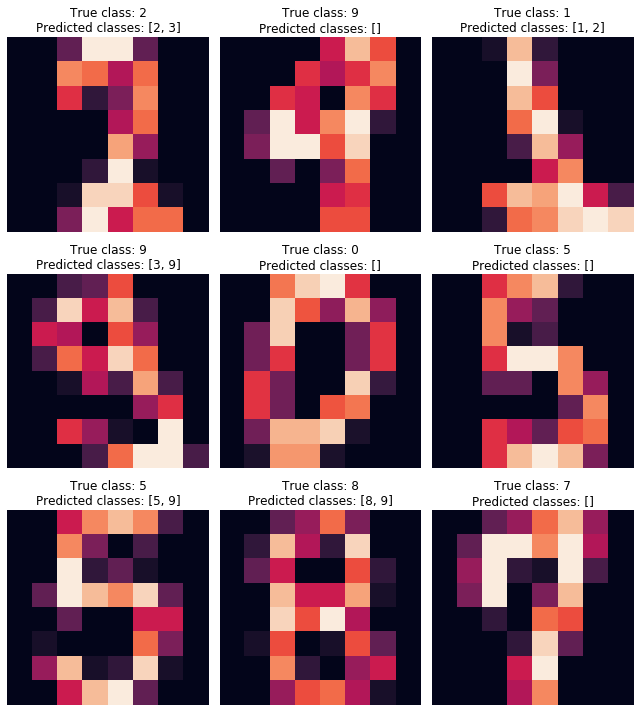

In [87]:
violations_idx = (y_pred_round[:, :-2].sum(axis=1)!=1)
violations = y_pred_round[violations_idx].astype(int)

print(f'Number of violations: {len(violations)} ({len(violations)/len(y_test)*100:.2f}%)')

plt.figure(figsize=(9, 10))
for i in range(9):
    true_class = y_test[violations_idx][i, :10].argmax().detach().numpy()
    predicted_classes = np.argwhere(y_pred_round[violations_idx][i, :10]).squeeze().tolist()
    
    plt.subplot(3, 3, i+1)
    plt.title(f'True class: {true_class}\nPredicted classes: {predicted_classes}')
    sns.heatmap(x_test[violations_idx][i].reshape((8, 8)), cbar=False)
    plt.axis('off')
plt.tight_layout()
plt.show()

## References

Gori, M. (2017). Machine Learning: A constraint-based approach. Morgan Kaufmann.

Marra, G., Giannini, F., Diligenti, M., & Gori, M. (2019). Lyrics: a general interface layer to integrate ai and deep learning. arXiv preprint arXiv:1903.07534.

Ciravegna, G., Giannini, F., Gori, M., Maggini, M., & Melacci, S. Human-Driven FOL Explanations of Deep Learning. In 29th International Joint Conference on Artificial Intelligence (pp. 2234-2240).